# DE-NOISING COVARIANCES MATRICES

**GOAL**: test a method to reduce noise and increase the signal included in an empirical covariance matrix

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_valvec, mp_pdf, fitKDE, covToCorr, find_max_eVal, denoiseCorr_CRE

## A. Totally random empirical correlation matrix

Demonstrate how well the theoretical distribution of Marchenko-Pastur explains well the eigenvalues of a random matrix X

$X$ is a matrix of i.i.d. random variables with size $TxN$.  
The underlying process generating the observations has mean $\mu=0$ and variance $\sigma^2$.  
Consider $q=T/N$ and the eigenvalues $\lambda$ of the matrix $T^{-1}X'X$.  
Keeping $1<q<+\infty$, we have that
$$\lim_{N,T\rightarrow +\infty}\lambda=f[\lambda]$$
where
$$f[\lambda]=\begin{cases}q\frac{\sqrt{(\lambda_{+}-\lambda)(\lambda-\lambda_{-})}}{2\pi\lambda\sigma^2} & \mbox{if } \lambda\in [\lambda_{-},\lambda_{+}] \\ 0 & \mbox{if } \lambda\notin [\lambda_{-},\lambda_{+}]  \end{cases}$$
is the Marcenko-Pastur PDF.  
$\lambda_{+}=\sigma^2 \left(1+\sqrt{\frac{1}{q}}\right)^2$ is the maximum expected eigenvalue and  
$\lambda_{-}=\sigma^2 \left(1-\sqrt{\frac{1}{q}}\right)^2$ is the minimum expected eigenvalue.  
When $\sigma^2=1$ then $C$ is the correlation matrix associated with $X$.  
Eigenvalues between minimum and maximum expected eigenvalues are consistent with random behavior, and other eigenvalues are consistent with nonrandom behavior.  
In particular, eigenvalues $\lambda\in [0, \lambda_{+}]$ are associated with noise in randomness.

### EXPERIMENT
All used functions are written in the script *utils.py*

In [2]:
# Shape of the matrix X
int_T = 10000
int_N = 1000
flt_q = int_T/int_N

# Definition of X as TOTALLY RANDOM empirical matrix
lst_X = np.random.normal(size=(int_T, int_N))

# Empirical covariance matrix (perfectly random)
# (i.e., the theoretical case with variance=1)
lst_emp_C = np.corrcoef(x=lst_X,
                        rowvar=False)

# Extract eigenvalues and eigenvectors from empirical correlation matrix
lst_eVals_emp, lst_eVecs_emp = get_valvec(lst_matrix=lst_emp_C)

# Theoretical MP PDF (of course, the variance is equal to 1)
dtf_pdf_theo = mp_pdf(flt_var=1,
                      flt_q=flt_q,
                      int_num_eVals=1000)

# Empirical PDF, obtained by fitting a kernel (default: gaussian kernel) on the empirical eigenvalues
# Both PDFs are evaluated on the same 1000 evaluation points
dtf_pdf_emp = fitKDE(lst_obs=np.diag(lst_eVals_emp),
                     flt_bandwidth=0.01)

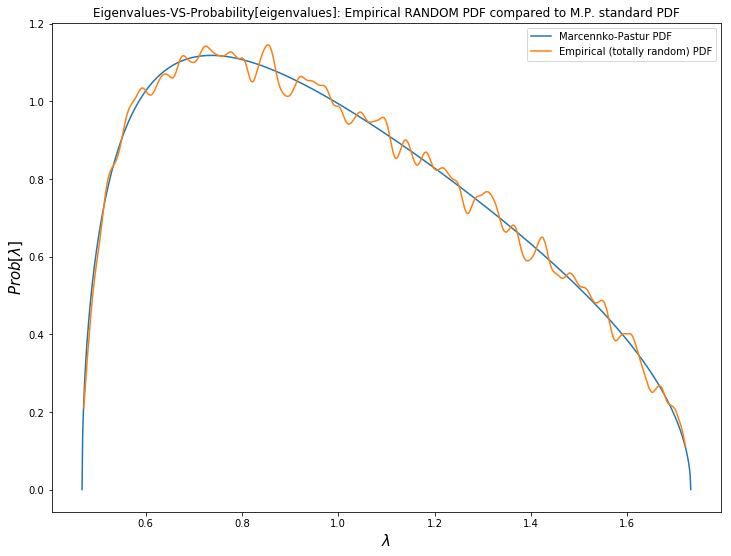

In [3]:
f = plt.figure(figsize=(12,9))
plt.plot(dtf_pdf_theo,
         label="Marcennko-Pastur PDF")

plt.plot(dtf_pdf_emp,
         label="Empirical (totally random) PDF")

plt.xlabel(xlabel="$\lambda$",
           size=15)

plt.ylabel(ylabel="$Prob[\lambda]$",
           size=15)

plt.legend()
plt.title("Eigenvalues-VS-Probability[eigenvalues]: Empirical RANDOM PDF compared to M.P. standard PDF")
plt.show()

## B. Empirical correlation matrix with signal and noise

Build a covariance matrix that is NOT PERFECTLY RANDOM.  
So, its eigenvalues will only approximately follow the Marcenko–Pastur PDF.  
To further dilute the signal, add that covariance matrix to a purely random matrix, with a weight alpha.

In [4]:
def not_random_cov(int_T, int_N, int_M, flt_alpha):
    """
    Function that builds a covariance matrix that is not perfectly random
    :param int_T: first dimension of the underlying process (number of observations)
    :param int_N: second dimension of the underlying process (number of variables)
    :param int_M: number of random variables (out of int_N) that contains some signal (factors)
    :param flt_alpha: weight for noise
    return: lst_cov: empirical covariance matrix with some signal and noise
    """
    ### SIGNAL PART OF COVARIANCE MATRIX ###
    # Random matrix lst_sig with size NxM (M<N)
    lst_sig = np.random.normal(size=(int_N, int_M))
    
    # Random covariance matrix, however not full rank (not all rows are linearly independent)
    lst_cov_sig = np.matmul(lst_sig, lst_sig.T)
    
    # Full rank covarince matrix: add uniform distributed values
    # Now all rows are linearly independent, with size NxN
    lst_cov_sig += np.diag(np.random.uniform(size=int_N))
    
    ### NOISE PART OF THE COVARIANCE MATRIX ###
    # Purely random noise covariance matrix, with size NxN
    # (out of a random matrix with size TxN)
    lst_cov_ran = np.cov(m=np.random.normal(size=(int_T, int_N)),
                         rowvar=False)

    # Weight the two parts with the parameter flt_alpha
    lst_cov = flt_alpha*lst_cov_ran + (1-flt_alpha)*lst_cov_sig
    
    return lst_cov

### EXPERIMENT
All used functions are written in the script *utils.py* with the exception of the function *not_random_cov* written above

In [5]:
# Parameters
int_T = 10000
int_N = 1000
int_M = 100
flt_alpha = 0.995
flt_q = int_T/int_N

# Build a empirical covariance matrix not perfectly random
lst_cov = not_random_cov(int_T=int_T,
                         int_N=int_N,
                         int_M=int_M,
                         flt_alpha=flt_alpha)

# Obtain the associated empirical correlation matrix
lst_corr = covToCorr(lst_cov=lst_cov)

# Proceed as in the totally random case, i.e.
# trying to fit the distribution of the empirical eigenvalues with MP PDF with variance equal to 1
lst_eVals_emp, lst_eVecs_emp = get_valvec(lst_matrix=lst_corr)

First of all, try to compare the distribution of empirical eigenvalues with the standard theoretical MP distribution  
(i.e. with variance equal to 1)

In [6]:
# Theoretical MP pdf
dtf_pdf_theo = mp_pdf(flt_var=1,
                      flt_q=flt_q,
                      int_num_eVals=1000)

# Empirical pdf
dtf_pdf_emp = fitKDE(lst_obs=np.diag(lst_eVals_emp),
                     flt_bandwidth=0.01)

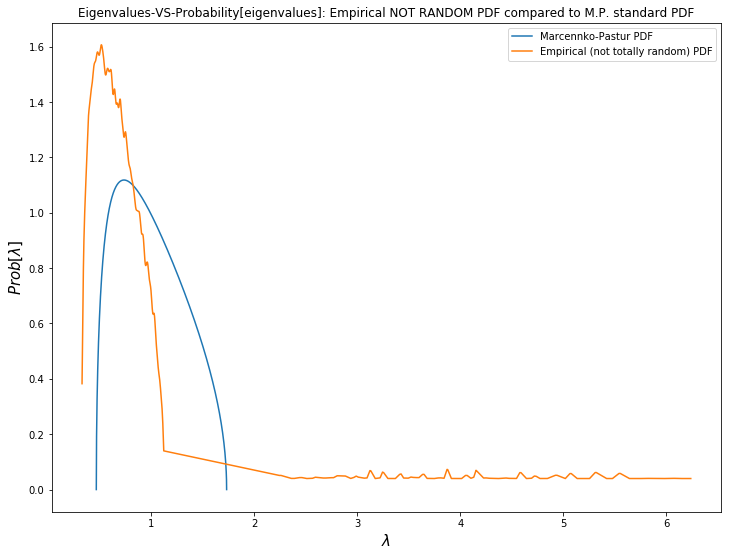

In [7]:
f = plt.figure(figsize=(12,9))
plt.plot(dtf_pdf_theo,
         label="Marcennko-Pastur PDF")

plt.plot(dtf_pdf_emp,
         label="Empirical (not totally random) PDF")

plt.xlabel(xlabel="$\lambda$",
           size=15)

plt.ylabel(ylabel="$Prob[\lambda]$",
           size=15)

plt.legend()
plt.title("Eigenvalues-VS-Probability[eigenvalues]: Empirical NOT RANDOM PDF compared to M.P. standard PDF")
plt.show()

Only part of the variance is caused by random eigenvectors, so we have to adjust the variance $\sigma^2$.  
We fit the function $f[\lambda]$ on the empirical distribution of the eigenvalues in order to find the variance $\sigma^2$ that minimizes the quadratic difference between the theoretical (as function of the $\sigma^2$) and empirical PDFs, both evaluated on the same points.  
Then from that variance we obtain the maximum eigenvalue with the formula of MP, i.e.  
$\lambda_{+}=\sigma^2\left(1+\sqrt{\frac{1}{q}}\right)^2$  
That gives us the variance that is explained by the random eigenvectors of the correlation matrix, and it determines the cutoff level $\lambda_{+}$, adjusted for the presence of nonrandom eigenvectors.

In [8]:
flt_bandwidth = 0.01

# Find the maximum expected eigenvalue and the corresponding variance
flt_max_eVal_emp, flt_var_emp = find_max_eVal(lst_eVals=np.diag(lst_eVals_emp),
                                              flt_q=flt_q,
                                              flt_bandwidth=flt_bandwidth)

# Theoretical MP pdf wiith EMPIRICAL ESTIMATED VARIANCE
dtf_pdf_theo = mp_pdf(flt_var=flt_var_emp,
                      flt_q=flt_q,
                      int_num_eVals=1000)

# Empirical pdf
dtf_pdf_emp = fitKDE(lst_obs=np.diag(lst_eVals_emp),
                     flt_bandwidth=flt_bandwidth)

int_nFacts = lst_eVals_emp.shape[0]-np.diag(lst_eVals_emp)[::-1].searchsorted(flt_max_eVal_emp)

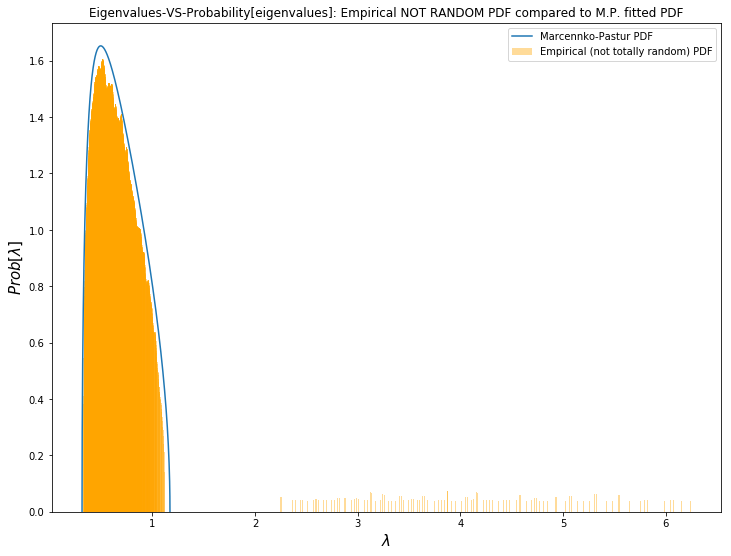

In [9]:
f = plt.figure(figsize=(12,9))
plt.plot(dtf_pdf_theo,
         label="Marcennko-Pastur PDF")

plt.bar(x=dtf_pdf_emp.index,
        height=dtf_pdf_emp,
        width=0.01,
        alpha=0.4,
        color="orange",
        label="Empirical (not totally random) PDF")

plt.xlabel(xlabel="$\lambda$",
           size=15)

plt.ylabel(ylabel="$Prob[\lambda]$",
           size=15)

plt.legend()
plt.title("Eigenvalues-VS-Probability[eigenvalues]: Empirical NOT RANDOM PDF compared to M.P. fitted PDF")
plt.show()

In [10]:
print("Variance that can be attributed to signal:",round((1-flt_var_emp)*100,2),"%, due to arbitrage forces")
print("Number of factores (eigenvalues related to signal):",int_nFacts,", the same number of factors injected to the covariance matrix")

Variance that can be attributed to signal: 32.33 %, due to arbitrage forces
Number of factores (eigenvalues related to signal): 100 , the same number of factors injected to the covariance matrix


As we can see from the plot, the eigenvalues "to the right" of the MP PDF are not connected to the noise as they are related to the signal.  
The code returns the number of these values: 100, exactly **what we had passed as a parameter**.
We also note that the variance explained by the random behavior is 67.69%, therefore **32.41% is due to signal** (arbitrage forces).  
So, despite the noise present in the covariance matrix, the procedure has been able to **separate the eigenvalues associated with noise from the eigenvalues associated with signal**.

## C. Denoise correlation matrix

The idea now is to use the previous technique (which allows to separate eigenvalues due to noise from those due to signal) to denoise the correlation matrix.  
This is done by the **Constant Residual Eigenvalue Method**, which consists in setting a  constant eigenvalue for each random eigenvector.  
If $\{\lambda_{n}\}_{n=1}^{N}$ is the set of descending ordered eigenvalues and $i$ is the index such that  
$\lambda_{i}>\lambda_{+}$ and $\lambda_{i+1}\leq\lambda_{+}$, set  
$\lambda_{j}=1/\left(N-i\right)\Sigma_{k=i+1}^{N}\lambda_{k}$ for $j=i+1,...,N$.
Doing so, we preserv the trace of the correlation matrix.  
Considering the eigenvector decomposition $VW=W\Lambda$, the denoised matrix $C_{1}$ is given by the following transformations:  
$$C_{0}=W\widetilde{\Lambda}W'$$
$$C_{1}=C_{0}\left[\left(diag\left[C_{0}\right]\right)^{\frac{1}{2}}{\left(diag\left[C_{0}\right]\right)^{\frac{1}{2}}}'\right]^{-1}$$
where $\widetilde{\Lambda}$ is the diagonal matrix with the corrected eigenvalues and $diag$ dictates to zero all non-diagonal elements of a squared matrix.

### EXPERIMENT
All used functions are written in the script *utils.py*

In [11]:
# Example: de-noise previous empirical correlation matrix
lst_corr_den = denoiseCorr_CRE(lst_eVals=lst_eVals_emp,
                               lst_eVecs=lst_eVecs_emp,
                               int_nFacts=int_nFacts)

# Extract new eigenvalues and eigenvectors
lst_eVals_emp_den, lst_eVecs_emp_den= get_valvec(lst_matrix=lst_corr_den)

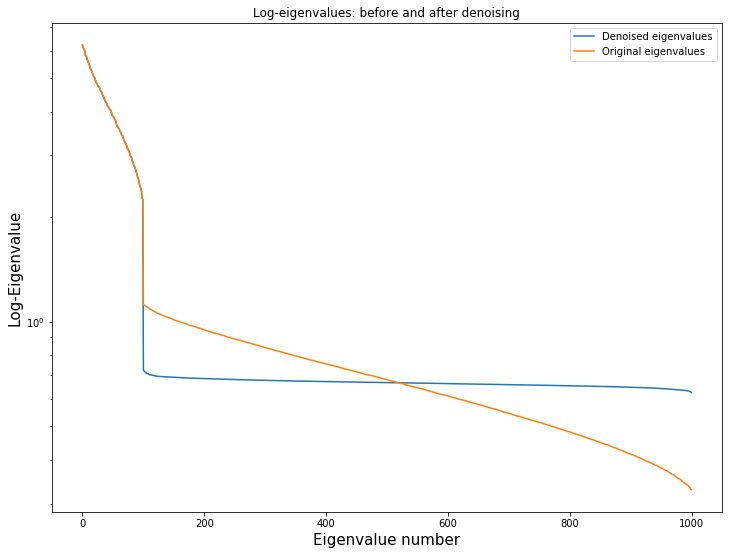

In [12]:
f = plt.figure(figsize=(12,9))
plt.plot(np.diag(lst_eVals_emp_den),
         label="Denoised eigenvalues")

plt.plot(np.diag(lst_eVals_emp),
         label="Original eigenvalues")

plt.xlabel(xlabel="Eigenvalue number",
           size=15)

plt.ylabel(ylabel="Log-Eigenvalue",
           size=15)

plt.yscale(value="log")
plt.legend()
plt.title("Log-eigenvalues: before and after denoising")
plt.show()

This method appears to remove noise by preserving the signal

## D. EXPERIMENTAL RESULT: *MINIMUM VARIANCE PORTFOLIO*

Working with denoised covariance matrices renders substantial benefits  
(1) Those benefits result from the mathematical properties of those treated matrices  
(2) They can be evaluated through Monte Carlo experiments  
**Example**  
Two characteristic portfolios of the efficient frontier:  
(a) The minimum variance solution  
(b) The maximum Sharpe ratio solution  
Any member of the unconstrained efficient frontier can be derived as a convex combination of (a) and (b). Here we focus on the first one.

Let's run the following Monte Carlo experiment:  
(1) Perform 1000 iterations  
(2) Draw a random empirical covariance matrix with T=1000  
(3) Denoise the empirical covariance matrix  
(4) Derive the minimum variance portfolio

In [13]:
def minVar_port(lst_cov, lst_mu=None):
    """
    Function that calculates the minimum variance portfolio out of an empirical covariance matrix
    :param lst_cov: empirical covariance matrix
    :param lst_mu: list of empirical means (default: None)
    return: lst_w: list of weights of the portfolio
    """
    lst_cov_inv = np.linalg.inv(lst_cov)
    lst_ones = np.ones(shape=(lst_cov_inv.shape[0], 1))
    if lst_mu is None:
        lst_mu = lst_ones
        
    lst_w = np.dot(lst_cov_inv, lst_mu)
    lst_w /= np.dot(lst_ones.T, lst_w)
    return lst_w

### EXPERIMENT
All used functions are written in the script *utils.py* with the exception of the function *minVar_port* written above

We base the experiment on a realistic, not empirical matrix.  
So we create a REAL (realistic) covariance matrix along with its vector of means.  
The covariance matrix is made out of a given correlation matrix:  
(a) out of a given number of blocks  
(b) each block has a given size  
(c) each offdiagonal elements within each block have a given correlation  
This covariance matrix is a  representation of a TRUE (nonempirical) detoned **correlation matrix of S&P500**.  
In fact, each block is associated with an **economic sector**.

In [14]:
from utils import formTrueMatrix, simulate_covMu, denoiseCov_CRE

In [15]:
### BUILD THE REAL COVARIANCE MATRIX ###
int_nBlocks = 10
int_bSize = 50
flt_bCorr = 0.5

np.random.seed(0)
lst_mu_real, lst_cov_real = formTrueMatrix(int_nBlocks=int_nBlocks,
                                           int_bSize=int_bSize,
                                           flt_bCorr=flt_bCorr)

In [16]:
### PARAMETERS ###
# Number of observations
int_T = 1000

# Number of trials in the experiment
int_nTrials = 1000

flt_bandwidth = 0.01

#### Errors associated with estimating a minimum variance portfolio with and without denoising

Estimate the quadratic errors in the construction of a minimal variance portfolio, with and without shrinkage

In [19]:
bln_minVarPort = True
dct_out_var = dict()

In [ ]:
### WHITOUT SHRINKAGE ###
bln_shrink = False

### INITIALIZE THE WEIGHTS ###
# Not-denoised matrix of weights
dtf_w = pd.DataFrame(columns=range(lst_cov_real.shape[0]),
                     index=range(int_nTrials),
                     dtype=float)

# Calculate denoised matrix of weights
dtf_w_den = dtf_w.copy(deep=True)

np.random.seed(0)
for int_i in range(int_nTrials):
    if int_i % 100 == 0:
        print("SIMULATED",int_i,"of",int_nTrials)
        
    # Empirical means and covariance matrix
    lst_mu_emp, lst_cov_emp = simulate_covMu(lst_mu=lst_mu_real,
                                             lst_cov=lst_cov_real,
                                             int_T=int_T,
                                             bln_shrink=bln_shrink)
    
    if bln_minVarPort:
        lst_mu_emp = None
        
    lst_cov_emp_den = denoiseCov_CRE(lst_cov=lst_cov_emp,
                                     flt_q=int_T/lst_cov_emp.shape[1],
                                     flt_bandwidth=flt_bandwidth)
    
    dtf_w.loc[int_i] = minVar_port(lst_cov=lst_cov_emp,
                                   lst_mu=lst_mu_emp).flatten()
    
    dtf_w_den.loc[int_i] = minVar_port(lst_cov=lst_cov_emp_den,
                                       lst_mu=lst_mu_emp).flatten()
    
lst_w_theo = minVar_port(lst_cov=lst_cov_real,
                         lst_mu=None if bln_minVarPort else lst_mu_real)

lst_w_theo = np.repeat(lst_w_theo.T,
                       dtf_w.shape[0],
                       axis=0)

flt_rmse = np.sqrt(np.mean(np.square((dtf_w-lst_w_theo).values.flatten())))
flt_rmse_den = np.sqrt(np.mean(np.square((dtf_w_den-lst_w_theo).values.flatten())))

dct_out_var["NOT SHRUNK"] = [flt_rmse, flt_rmse_den]

SIMULATED 0 of 1000


In [ ]:
### WITH SHRINKAGE ###
bln_shrink = True

### INITIALIZE THE WEIGHTS ###
# Not-denoised matrix of weights
dtf_w = pd.DataFrame(columns=range(lst_cov_real.shape[0]),
                     index=range(int_nTrials),
                     dtype=float)

# Calculate denoised matrix of weights
dtf_w_den = dtf_w.copy(deep=True)

np.random.seed(0)
for int_i in range(int_nTrials):
    if int_i % 100 == 0:
        print("SIMULATED",int_i,"of",int_nTrials)
        
    # Empirical means and covariance matrix
    lst_mu_emp, lst_cov_emp = simulate_covMu(lst_mu=lst_mu_real,
                                             lst_cov=lst_cov_real,
                                             int_T=int_T,
                                             bln_shrink=bln_shrink)
    
    if bln_minVarPort:
        lst_mu_emp = None
        
    lst_cov_emp_den = denoiseCov_CRE(lst_cov=lst_cov_emp,
                                     flt_q=int_T/lst_cov_emp.shape[1],
                                     flt_bandwidth=flt_bandwidth)
    
    dtf_w.loc[int_i] = minVar_port(lst_cov=lst_cov_emp,
                                   lst_mu=lst_mu_emp).flatten()
    
    dtf_w_den.loc[int_i] = minVar_port(lst_cov=lst_cov_emp_den,
                                       lst_mu=lst_mu_emp).flatten()
    
lst_w_theo = minVar_port(lst_cov=lst_cov_real,
                         lst_mu=None if bln_minVarPort else lst_mu_real)

lst_w_theo = np.repeat(lst_w_theo.T,
                       dtf_w.shape[0],
                       axis=0)

flt_rmse = np.sqrt(np.mean(np.square((dtf_w-lst_w_theo).values.flatten())))
flt_rmse_den = np.sqrt(np.mean(np.square((dtf_w_den-lst_w_theo).values.flatten())))
dct_out_var["SHRUNK"] = [flt_rmse, flt_rmse_den]

In [ ]:
dtf_output = pd.DataFrame(data=dct_out_var,
                          index=["NOISED","DE-NOISED"])

dtf_output